Using device: cuda
Epoch [0/150000], Loss: 0.7224, Val Loss: 0.7252
Epoch [1000/150000], Loss: 0.5816, Val Loss: 0.5970
Epoch [2000/150000], Loss: 0.5259, Val Loss: 0.5486
Epoch [3000/150000], Loss: 0.4963, Val Loss: 0.5241
Epoch [4000/150000], Loss: 0.4780, Val Loss: 0.5097
Epoch [5000/150000], Loss: 0.4654, Val Loss: 0.5003
Epoch [6000/150000], Loss: 0.4561, Val Loss: 0.4939
Epoch [7000/150000], Loss: 0.4491, Val Loss: 0.4893
Epoch [8000/150000], Loss: 0.4435, Val Loss: 0.4859
Epoch [9000/150000], Loss: 0.4390, Val Loss: 0.4834
Epoch [10000/150000], Loss: 0.4353, Val Loss: 0.4815
Epoch [11000/150000], Loss: 0.4321, Val Loss: 0.4800
Epoch [12000/150000], Loss: 0.4294, Val Loss: 0.4789
Epoch [13000/150000], Loss: 0.4271, Val Loss: 0.4780
Epoch [14000/150000], Loss: 0.4250, Val Loss: 0.4773
Epoch [15000/150000], Loss: 0.4232, Val Loss: 0.4768
Epoch [16000/150000], Loss: 0.4216, Val Loss: 0.4763
Epoch [17000/150000], Loss: 0.4201, Val Loss: 0.4760
Epoch [18000/150000], Loss: 0.4188, Val 

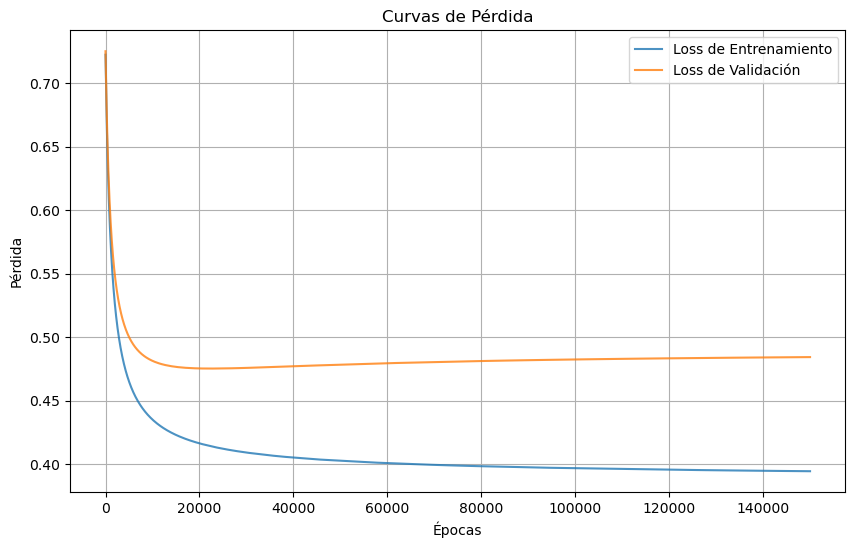

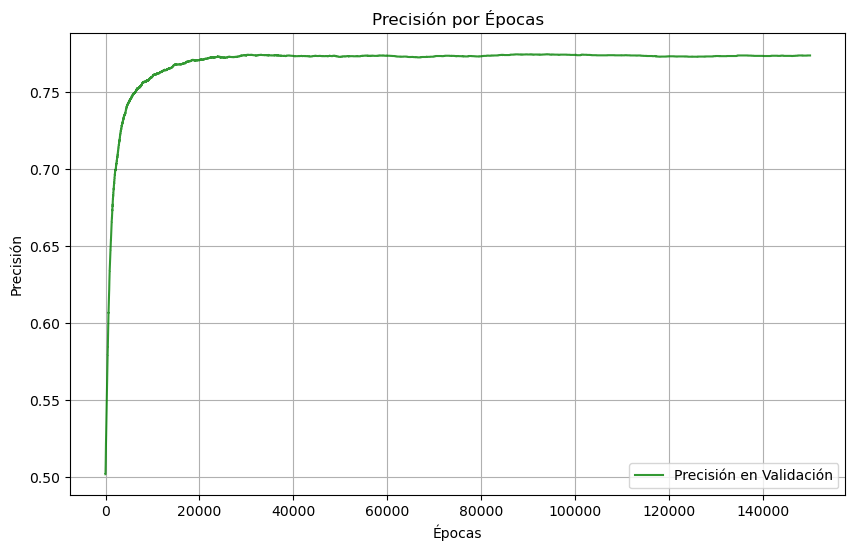

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from scipy.sparse.linalg import norm
from scipy.stats import zscore
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

#####################################
# Configuración de entorno y datos
#####################################

# Dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Cargar datasets
train_data = pd.read_csv("divisonDatos/train_data.csv", sep=";")
val_data = pd.read_csv("divisonDatos/val_data.csv", sep=";")
test_data = pd.read_csv("divisonDatos/test_data.csv", sep=";")

# Remover filas con datos faltantes
train_data = train_data.dropna(subset=['Texto', 'Label'])
val_data = val_data.dropna(subset=['Texto', 'Label'])
test_data = test_data.dropna(subset=['Texto', 'Label'])

# Separar características y etiquetas
X_train = train_data['Texto']
y_train = train_data['Label']

X_val = val_data['Texto']
y_val = val_data['Label']

X_test = test_data['Texto']
y_test = test_data['Label']

#####################################
# Preprocesamiento de texto
#####################################

# 1. Vectorización TF-IDF
tfidf_vectorizer_ngrams = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X_train_vec = tfidf_vectorizer_ngrams.fit_transform(X_train)
X_val_vec = tfidf_vectorizer_ngrams.transform(X_val)
X_test_vec = tfidf_vectorizer_ngrams.transform(X_test)

# 2. Selección de características (chi-cuadrado)
selector = SelectKBest(chi2, k=3000)
X_train_reduced = selector.fit_transform(X_train_vec, y_train)
X_val_reduced = selector.transform(X_val_vec)
X_test_reduced = selector.transform(X_test_vec)

# 3. Normalización de datos
scaler = StandardScaler(with_mean=False)
X_train_normalized = scaler.fit_transform(X_train_reduced)
X_val_normalized = scaler.transform(X_val_reduced)
X_test_normalized = scaler.transform(X_test_reduced)

# 4. Filtrado de outliers con z-score
row_norms = norm(X_train_normalized, axis=1)
z_scores = zscore(row_norms)
mask = np.abs(z_scores) < 2.5
X_train_cleaned = X_train_normalized[mask]
y_train_cleaned = y_train[mask]

#####################################
# Conversión a Tensores de PyTorch
#####################################

X_train_tensor = torch.tensor(X_train_cleaned.toarray(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_cleaned.values, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_val_normalized.toarray(), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test_normalized.toarray(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

#####################################
# Definición del modelo
#####################################

class LogisticRegressionTorch(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionTorch, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Crear el modelo
input_dim = X_train_tensor.shape[1]
model = LogisticRegressionTorch(input_dim).to(device)

#####################################
# Función de pérdida
#####################################

criterion = nn.BCELoss()

#####################################
# Parámetros de entrenamiento
#####################################

learning_rate = 0.0001
momentum = 0.8
epochs = 150000

#####################################
# Definir función de actualización (SGD con momentum)
#####################################

def sgd_momentum_step(model, velocities, lr=0.0001, momentum=0.8):
    with torch.no_grad():
        for param, v in zip(model.parameters(), velocities):
            if param.grad is not None:
                v.mul_(momentum).add_(param.grad, alpha=-lr)
                param.add_(v)

velocities = [torch.zeros_like(param, device=device) for param in model.parameters()]
# Variables para almacenar las pérdidas
losses_train = []
losses_val = []
gradients = []
accuracies_val = []

for epoch in range(epochs):
    model.train()
    model.zero_grad()

    # Cálculo de la pérdida de entrenamiento
    outputs = model(X_train_tensor).squeeze()
    loss = criterion(outputs, y_train_tensor)
    losses_train.append(loss.item())
    
    loss.backward()
    sgd_momentum_step(model, velocities, lr=learning_rate, momentum=momentum)

    # Evaluación en el conjunto de validación
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor).squeeze()
        val_loss = criterion(val_outputs, y_val_tensor)
        losses_val.append(val_loss.item())

        # Precisión en validación
        val_predictions = (val_outputs > 0.6).float()
        val_accuracy = accuracy_score(y_val_tensor.cpu().numpy(), val_predictions.cpu().numpy())
        accuracies_val.append(val_accuracy)

    # Calcular el gradiente promedio
    avg_grad = torch.mean(torch.stack([torch.mean(param.grad.abs()) for param in model.parameters() if param.grad is not None]))
    gradients.append(avg_grad.item())

    # Imprimir cada 100 épocas
    if epoch % 1000 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

#####################################
# Evaluación en Validación
#####################################

model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor).squeeze()
    val_predictions = (val_outputs > 0.6).float()
    val_precision = precision_score(y_val_tensor.cpu().numpy(), val_predictions.cpu().numpy())
    val_accuracy = accuracy_score(y_val_tensor.cpu().numpy(), val_predictions.cpu().numpy())
    val_f1 = f1_score(y_val_tensor.cpu().numpy(), val_predictions.cpu().numpy())
    val_conf_matrix = confusion_matrix(y_val_tensor.cpu().numpy(), val_predictions.cpu().numpy())

print("\nValidation Metrics:")
print(f"Precision: {val_precision:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1-Score: {val_f1:.4f}")
print("Confusion Matrix:\n", val_conf_matrix)

#####################################
# Evaluación en Prueba
#####################################

with torch.no_grad():
    test_outputs = model(X_test_tensor).squeeze()
    test_predictions = (test_outputs > 0.6).float()
    test_precision = precision_score(y_test_tensor.cpu().numpy(), test_predictions.cpu().numpy())
    test_accuracy = accuracy_score(y_test_tensor.cpu().numpy(), test_predictions.cpu().numpy())
    test_f1 = f1_score(y_test_tensor.cpu().numpy(), test_predictions.cpu().numpy())
    test_conf_matrix = confusion_matrix(y_test_tensor.cpu().numpy(), test_predictions.cpu().numpy())

print("\nTest Metrics:")
print(f"Precision: {test_precision:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print("Confusion Matrix:\n", test_conf_matrix)

#####################################
# Visualización de Resultados
#####################################

# Gráfica de curvas de pérdida
plt.figure(figsize=(10, 6))
plt.plot(losses_train, label="Loss de Entrenamiento", alpha=0.8)
plt.plot(losses_val, label="Loss de Validación", alpha=0.8)
plt.title("Curvas de Pérdida")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.show()


# Gráfica de precisión por épocas
plt.figure(figsize=(10, 6))
plt.plot(accuracies_val, label="Precisión en Validación", color="green", alpha=0.8)
plt.title("Precisión por Épocas")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.grid(True)
plt.show()
